# UK House Prices in Python - (a) Data Gathering and Visualisation
#### David Miller - September 2020 - [Link to Github](https://github.com/millerdw/millerdw.github.io/tree/master/_notebooks/IllustratingThePoint_4)
---

It's been a while since my last post, but I've been busy. I've taken a year out to complete a Masters in Machine Learning at UCL, an experience I might talk about at a later time. For now let's just say it's been an intense 12 months. However, now September's rolled around, and I'm all done and dusted, I thought it was time to turn back to unfinished business. 

Early last year I did some work [visualising UK House Prices](https://millerdw.github.io/UK-House-Price-Visualisation/) using F#, MathNet.Numerics, and Plotly. It was mostly an exercise in demonstrating the use of these packages, but I enjoyed digging around in the data. It felt like a rich seam. So, 18 months later, I thought I'd have a 'proper' poke at managing geographic data using Python and Geopandas, and potentially modelling it using some simple machine learning techniques.

In this post I step through the process of gathering the geographic data, all open-sourced, and performing simple visualisations to better understand the distributions.

## Setup

As always, there's work to do before we begin, but here I've tried to keep it simple. I'm using `Python` v3.7, and have installed `pandas`, `geopandas`, and `matplotlib` using conda.

The cell below loads these libraries or relevant functions from then (note that `shapely` is installed as a dependency of `geopandas`).

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, LineString

import glob
from os import path, getcwd
from utils import ProgressBar

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator
%matplotlib inline

directory='data'

## UK House Price Index

First we'll take a look at the House Price Index in the UK over the last few years.

House prices have been subject to significant growth and inflation since the late 1980s, and this trend has shown little sign of abating, barring a small blip after the 2008 recession, and a dampening caused by uncertainty since the 2016 Brexit vote, and more recently Covid-19. 

I've downloaded the house price dataset direct from the UK Government's open data platform, which gives us a csv file of monthly data by geography from January 1995 to June 2020: 

- https://www.gov.uk/government/statistical-data-sets/uk-house-price-index-data-downloads-june-2020

You can do this manually, and I recommend always to check out the provider of your data before you use it. 

<!-- ![alt text]('https://github.com/millerdw/millerdw.github.io/blob/master/_notebooks/IllustratingThePoint_4/images/Gov_HPI_screenshot.png' "Logo Title Text 1") -->


### Data
In the cell below, I load the csv into a `pandas` dataframe, format the 'Date' column from `string` to `datetime`, and filter by region. The original file gives us information from all over the UK, so I've chosen 7 representative cities to compare:

In [49]:
# load from csv
house_price_index = pd.read_csv(path.join(directory,'CPI/UK-HPI-full-file-2020-06.csv'))
house_price_index = house_price_index.assign(Date = pd.to_datetime(house_price_index['Date'],
                                                                   format='%d/%m/%Y'))
# filter by region
house_price_index = house_price_index[house_price_index['RegionName'].isin(['Cambridge','Oxford','Inner London','Manchester',
                                                                            'Brighton and Hove','City of Edinburgh','Cardiff'])]


As always with pandas this is remarkably easy. 

### Maybe boomers had it easy...

Next, we want to take an immediate look at the dataset. Using `matplotlib`, I plot the time series of average house prices in each city. This is provided as a field, among others, in the government dataset that we downloaded and requires no calculation:  

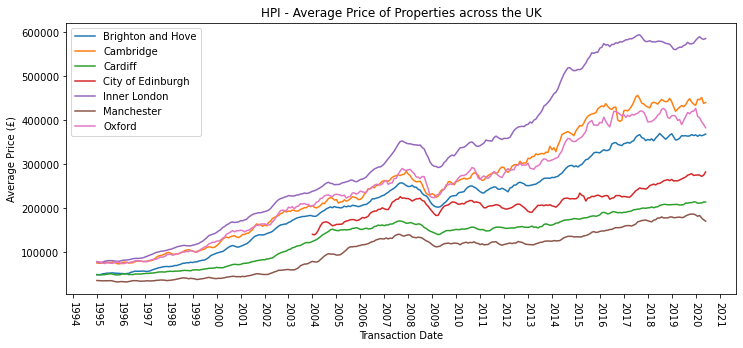

In [54]:
plt.figure(figsize=(12,5))
for region,group in house_price_index.groupby(['RegionName']):
    plt.plot(group['Date'],
             group['AveragePrice'],
             label=region)
plt.legend()
plt.title('HPI - Average Price of Properties across the UK')
plt.ylabel('Average Price (£)')
plt.xlabel('Transaction Date')
plt.xticks(rotation=-90)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(YearLocator())
plt.show()

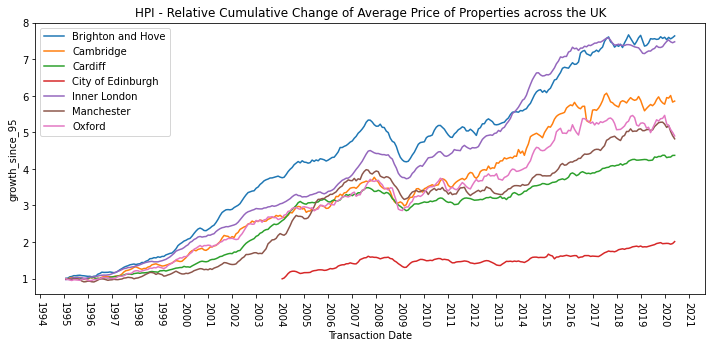

In [55]:
plt.figure(figsize=(12,5))
for region,group in house_price_index.groupby(['RegionName']):
    plt.plot(group['Date'],
             (1+group['AveragePrice'].pct_change()).cumprod(),
             label=region)
plt.legend()
plt.title('HPI - Relative Cumulative Change of Average Price of Properties across the UK')
plt.ylabel('growth_since_95')
plt.xlabel('Transaction Date')
plt.xticks(rotation=-90)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(YearLocator())
plt.show()

We can draw a few conclusions from these graphs:

- Unsurprisingly, London takes the top spot. The average house price in London has increased to nearly $8$ times it's original price in 1995.
- Perhaps more surprising, Brighton has seen growth as explosive as inner london. I grew up near Brighton and have seen the shift from a dirty, artsy (probably undervalued) student city in the 1990s to an expensive, hipster, london-commutable middle-class hideaway now. 
- Other cities on our list are equally London-commutable, see Oxford and Cambridge, and while they haven't seen the same level of growth, prices are now $5$ or $6$ times what they were 25 years ago.

### Insights
These numbers seem drastic (and disheartening to anyone trying to get on the property ladder), but there are a couple of mitigating factors:

> [Consumer prices](https://www.ons.gov.uk/economy/inflationandpriceindices/timeseries/l55o/mm23) excluding housing have also risen since 1995, to over $3$ times their original prices. This is known as consumer price inflation and, put simply, reflects how the value of a pound changes over time. If CPI increases $3$ times and house prices increase $8$ times in a given period, the 'real' average house price has only increased $\frac{8}{3}\approx 2.7$ times. Note that we intuitively expect wages to change in line with CPI, although there may be short and medium term deviations in this trend. Therefore, the 'average' London house costs nearly $3$ times as many paychecks now as it did in 1995.

> House prices are likely to have a right-skewed and clipped distributions; it's effectively impossible to have a negative house price, and therefore the average of house prices is likely to be skewed upwards compared to a more robust measure such as the median. This *shouldn't* have a systemic impact on the growth metric *unless* the relative number of high-end property transactions has changed compared to  the number of transactions involving middle-range or tighter budget properties. Unfortunately I don't have that data available, but it's always a thought to consider when using a bald average in your data.




### Property Types

Next we want to look at how the prices of different *types* of properties have changed over time. This information is also included in the government HPI dataset. We'd expect the growth of different properties within the same area to be closely bound as they all follow the trendss of the local area. Any differences in growth must be caused by systemic differences between types and are intuitively unlikely; for example a sudden dearth or glut of terraced houses compared to semi-detached houses.

In the cells below we filter the HPI data to the Cambridge region only, and plot the time series of AveragePrice for Detached, Semi-Detached, Terraced, and Flat property types: 

In [57]:
house_price_index = house_price_index[house_price_index['RegionName']=='Cambridge']

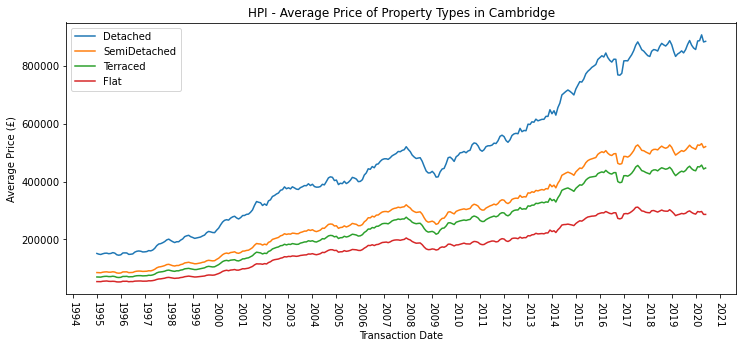

In [58]:
plt.figure(figsize=(12,5))
for house_type in ['Detached','SemiDetached','Terraced','Flat']:
    plt.plot(house_price_index['Date'],
             house_price_index[house_type+'Price'],
             label=house_type)
plt.legend()
plt.title('HPI - Average Price of Property Types in Cambridge')
plt.ylabel('Average Price (£)')
plt.xlabel('Transaction Date')
plt.xticks(rotation=-90)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(YearLocator())
plt.show()

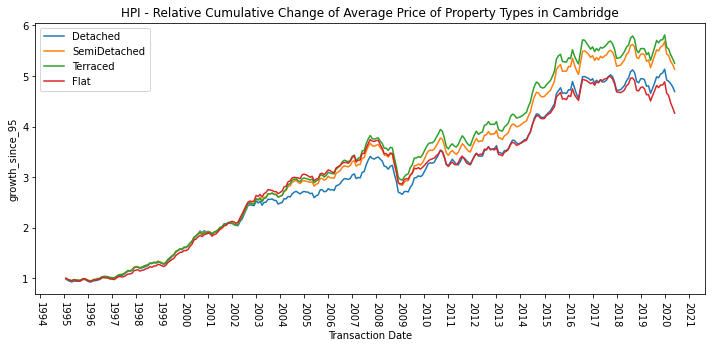

In [63]:
plt.figure(figsize=(12,5))
for house_type in ['Detached','SemiDetached','Terraced','Flat']:
    plt.plot(group['Date'],
             (1+group[house_type+'Price'].pct_change()).cumprod(),
             label=house_type)
plt.legend()
plt.title('HPI - Relative Cumulative Change of Average Price of Property Types in Cambridge')
plt.ylabel('growth_since_95')
plt.xlabel('Transaction Date')
plt.xticks(rotation=-90)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(YearLocator())
plt.show()

The graphs show that:
- Unsurprisingly there is a distinct and constant order of pricing for property types: Detached, Semi-Detached, Terraced, Flat 
- Semi-detached properties are only slightly more valued than Terraced properties, possibly because the 'Terraced' type includes end-of-terrace properties, which are effectively semi-detached.
- Detached property growth has lagged the others since 2003, similarly growth in Flat prices has lagged the other types since 2008


### Insights
> Data points in the long tail of the property price distribution (let's say properties over £1m for example) are more likely to be Detached properties, and therefore the average price of detached properties is more likely than the other types to be inflated by outliers.
<!-- 
> The apparent systemic differences in property type average price growth could be due to genuine systematic differences. For example, since the financial crisis in 2008, [year-on-year wage growth has softened](https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/timeseries/kab9/emp), and arguably it has become harder for first time buyers to save for deposits and win mortgages. The property most likely to be affected, or at least affected by the largest amount will be the cheapest, i.e. flats. -->

> Cumulative growth series can be easily knocked by a few single months of poor growth that are not corrected. These deviations are compounded over time, implying a long period of underperformance or outperformance that is illusory. As an example of this the month-by-month growth rates are shown in the cell below. 

> However, when the consumers can in theory move between property types, we should expect short term changes to correct themselves. There should be a form of arbitrage where buyers of cheaper property types stretch up to buy in the next class up. However the absolute difference in price is a practrical barrier, such that the current relative undervaluation of detached properties compared to semi-detached or terraced properties has existed for 10 years.

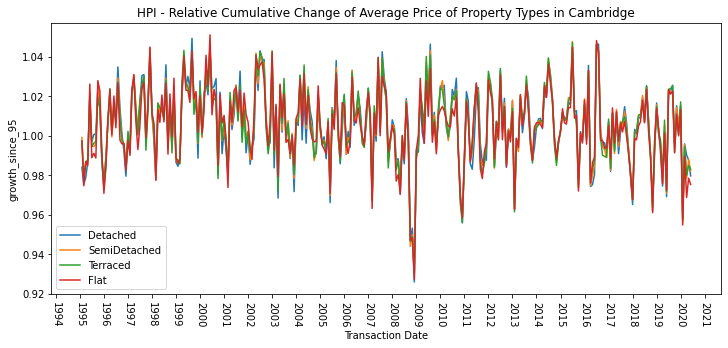

In [100]:
plt.figure(figsize=(12,5))
for house_type in ['Detached','SemiDetached','Terraced','Flat']:
    plt.plot(group['Date'],
             (1+group[house_type+'Price'].pct_change()),
             label=house_type)
plt.legend()
plt.title('HPI - Relative Cumulative Change of Average Price of Property Types in Cambridge')
plt.ylabel('growth_since_95')
plt.xlabel('Transaction Date')
plt.xticks(rotation=-90)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(YearLocator())
plt.show()

## Individual Transaction Data

### Data

Next we examine data for individual transations made available by the UK Land Registry. This transaction data contains information about sales of property in the uk; including Date, Price, and information about the property itself:

- https://www.gov.uk/topic/land-registration/data

This dataset comes with a postcode field, which allows us to look up the geographical position of each transaction using Postcode-Coordinates translation data. This data is available from the Office of National Statistics:

- https://ons.maps.arcgis.com/home/item.html?id=abd42fce1e944431b4f24881b5bb048d




### Postcodes

In the UK we use postcodes to represent collections of addresses; for example streets and blocks of flats. I downloaded the dataset described above to the 'data/Postcodes' directory. It consists of a list of csv files, each containing Postcode and Northing-Easting coordinates for a given region. 

In the cell below, these csv files are read and their contents merged into a single `pandas` dataframe.

In [2]:
# load csv file using pandas
postcode_coords = pd.concat((pd.read_csv(f, usecols=[0,2,3], header=0, names=['postcode','x','y'])
                             for f in glob.glob(path.join(directory,'Postcodes/*.csv'))))

# remove white space from postcode column
postcode_coords = postcode_coords.assign(postcode = postcode_coords['postcode'].str.replace(' ', ''))


Next, we want to import this dataset into a proper geospatial data handling library; `geopandas`. According to the [docs](https://geopandas.org/):
> *GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.*

`geopandas` provides a `GeoDataFrame` class that helpfully provides many geospatial data handling functions. It is based on the ubiquitous `pandas` `DataFrame`, and manages coordinates in a special `GeoSeries` class containing geometries from the `shapely` library.

The main superficial differences between a `GeoDataFrame` and its parent `DataFrame` are these geometries and the `.cx` property, that allows indexing by `GeoDataFrame` coordinates rather than `DataFrame` row.

Finally, combining geospatial data can be complicated, especially if two pieces of data use different coordinate systems ([Latitude and Longitude](https://en.wikipedia.org/wiki/Geographic_coordinate_system#Latitude_and_longitude) vs [OS Grid Reference](https://en.wikipedia.org/wiki/Ordnance_Survey_National_Grid) vs [Northing and Easting](https://en.wikipedia.org/wiki/Easting_and_northing) coordinates) or different map projections ([Mercator](https://en.wikipedia.org/wiki/Mercator_projection) vs [Equi-Rectangular](https://en.wikipedia.org/wiki/Equirectangular_projection) vs [Gal-Peters](https://en.wikipedia.org/wiki/Gall%E2%80%93Peters_projection) projection). In order to account for these differences, Coordinate Reference Systems are encoded in `GeoDataFrame` instances, with projections and translations managed by the `geopandas` library.

Our data is pulled direct from csv, but all instances use Northing and Easting coordinates from the ['OSGB 1936 / British National Grid'](https://epsg.io/27700) system. In the cell below we use an [ESRI WKT (Well-Known Text)](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) string representation of the system, extracted from the [epsg.io](https://epsg.io/27700) website, to encode it in the `GeoDataFrame`:


In [3]:
# define crs
crs = 'PROJCS["OSGB_1936_British_National_Grid",GEOGCS["GCS_OSGB 1936",DATUM["D_OSGB_1936",SPHEROID["Airy_1830",6377563.396,299.3249646]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["Meter",1]]'

# convert to geodataframe
postcode_coords = gpd.GeoDataFrame(postcode_coords,
                                   geometry = gpd.points_from_xy(postcode_coords['x'],
                                                                 postcode_coords['y']),
                                   crs=crs)

# clip to correct geography
postcode_coords = postcode_coords.cx[520000:575000,235000:280000]

Note that we have clipped the postcodes to a predetermined set of coordinates to focus on the Cambridge area, rather than the whole of the UK, as in my [previous post](https://millerdw.github.io/UK-House-Price-Visualisation/).

### House Prices

Next we download the historical transaction data in chunks (so as to manage the large file size), and merge this information with the postcode coordinate data. By using an inner join, this automatically filters out transactions with unknown postcodes (a very small proportion) and transactions from outside of the Cambridge area.

The cell below performs this load/merge operation, and converts the resulting data into a `GeoDataFrame` like the postcode data (this may take a couple of minutes to run):

In [4]:
# use chunking to manage large file, remove whitespace from Postcode column and merge with postcode_coords 
house_prices = pd.concat((pd.merge(chunk.assign(Postcode = chunk['Postcode'].str.replace(' ', '')),
                                   postcode_coords,
                                   how='inner',left_on='Postcode', right_on='postcode') 
                           for chunk in pd.read_csv(path.join(directory,
                                                              'HousePrices/LandRegistry_HousePrices_Full.csv'), 
                                                    chunksize=1e6))) 

# convert to geodataframe
house_prices = gpd.GeoDataFrame(house_prices,
                                geometry = gpd.points_from_xy(house_prices['x'],
                                                              house_prices['y']),
                                crs=crs)

# save to new csv
house_prices.to_csv(path.join(directory,'HousePrices/house_prices_full_local.csv'))

The resulting dataset contains more than 260,000 entries reaching back to 1995, each with the date of the transaction, the property type, address, geospatial coordinates, and the price paid for it, among a number of other fields.

The cells below show the column counts and the first 5 entries in the dataset:

In [5]:
house_prices.count()

Transaction unique identifier        261703
Price                                261703
Date of Transfer                     261703
Postcode                             261703
Property Type                        261703
Old/New                              261703
Duration                             261703
PAON                                 261697
SAON                                  14752
Street                               260391
Locality                             204985
Town/City                            261703
District                             261703
County                               261703
PPD Category Type                    261703
Record Status - monthly file only    261703
postcode                             261703
x                                    261703
y                                    261703
geometry                             261703
dtype: int64

In [96]:
house_prices.head()

,Transaction unique identifier,Price,Date of Transfer,Postcode,Property Type,Old/New,Duration,PAON,SAON,Street,Locality,Town/City,District,County,PPD Category Type,Record Status - monthly file only,postcode,x,y,geometry
0,{E76CCDAE-3A80-434F-99C3-91F5106F74E3},35200,1995-06-09 00:00,SG75LW,F,N,L,THE MALTINGS,FLAT 11,GREEN LANE,ASHWELL,BALDOCK,NORTH HERTFORDSHIRE,HERTFORDSHIRE,A,A,SG75LW,527291,239988,POINT (527291.000 239988.000)
1,{68405155-0EF8-47F5-A7E7-87D70D4AFE4D},46000,1995-06-16 00:00,SG75LW,F,N,L,THE MALTINGS,FLAT 18,GREEN LANE,ASHWELL,BALDOCK,NORTH HERTFORDSHIRE,HERTFORDSHIRE,A,A,SG75LW,527291,239988,POINT (527291.000 239988.000)
2,{CAF8C257-E364-466D-89DB-8BF83F78854B},38650,1995-09-29 00:00,SG75LW,F,N,L,THE MALTINGS,FLAT 6,GREEN LANE,ASHWELL,BALDOCK,NORTH HERTFORDSHIRE,HERTFORDSHIRE,A,A,SG75LW,527291,239988,POINT (527291.000 239988.000)
3,{64352770-A858-4DAC-9B5E-0F3973D6E113},42000,1995-02-20 00:00,SG75LW,F,N,L,THE MALTINGS,FLAT 9,GREEN LANE,ASHWELL,BALDOCK,NORTH HERTFORDSHIRE,HERTFORDSHIRE,A,A,SG75LW,527291,239988,POINT (527291.000 239988.000)
4,{D53B4676-DAAC-4008-B504-287263FB16CC},43975,1995-10-06 00:00,SG75LW,F,N,L,THE MALTINGS,FLAT 19,GREEN LANE,ASHWELL,BALDOCK,NORTH HERTFORDSHIRE,HERTFORDSHIRE,A,A,SG75LW,527291,239988,POINT (527291.000 239988.000)


## Visualising Transactions

Having collated our house transaction data our next step is to explore it visually.

As shown in the HPI exploration, house prices in Cambridge have been relatively level since the start of 2016. Therefore we filter our dataset to the last 4 years to make the prices more comparable:

In [13]:
# filter by date
house_prices_latest=house_prices[(house_prices['Date of Transfer']>='2016-01-01')]

### Price Distributions

The cell below plots the histograms of prices of different orders of magnitude:

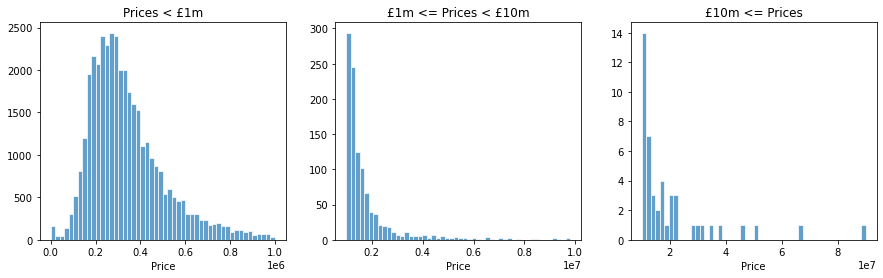

In [152]:
fig,ax=plt.subplots(1,3, figsize=(15,4))
ax[0].hist(house_prices_latest[house_prices_latest['Price']<1e6]['Price'], bins=50,
           alpha=0.7,ec='white')
ax[0].set_title('Prices < £1m')
ax[0].set_xlabel('Price')
ax[1].hist(house_prices_latest[(house_prices_latest['Price']>=1e6) & (house_prices_latest['Price']<1e7)]['Price'], bins=50,
           alpha=0.7,ec='white')
ax[1].set_title('£1m <= Prices < £10m')
ax[1].set_xlabel('Price')
ax[2].hist(house_prices_latest[house_prices_latest['Price']>=1e7]['Price'], bins=50,
           alpha=0.7,ec='white')
ax[2].set_title('£10m <= Prices')
ax[2].set_xlabel('Price')
plt.show()

The distribution of prices is clearly skewed, as expected.  A very small number of properties were apparently sold for >£10m (right hand graph). These were either erroneous or extreme outliers, and given they are outside the range of the average house-buyer's budget (at least mine), they can safely be ignored in future analysis.

We see that the vast majority of properties sold were priced between £100k and £1m, and in the cell below I show the histograms of both prices and the logs of prices within that range:

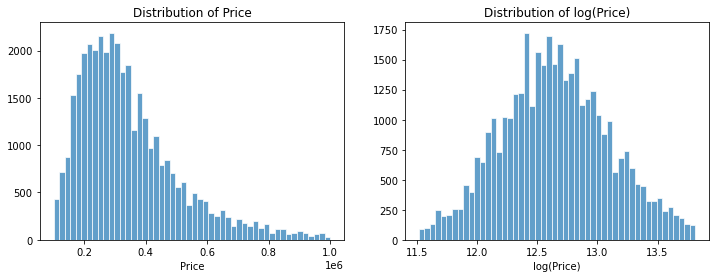

In [163]:
import numpy as np

fig,ax =plt.subplots(1,2, figsize=(12,4))

ax[0].hist(house_prices_latest[(house_prices_latest['Price']>=1e5) & (house_prices_latest['Price']<1e6)]['Price'], 
           bins=50,alpha=0.7,ec='white')
ax[0].set_title('Distribution of Price')
ax[0].set_xlabel('Price')
ax[1].hist(np.log(house_prices_latest[(house_prices_latest['Price']>=1e5) & (house_prices_latest['Price']<1e6)]['Price']), 
           bins=50,alpha=0.7,ec='white')
ax[1].set_title('Distribution of log(Price)')
ax[1].set_xlabel('log(Price)')
plt.show()

As a rough and ready fix, clipping data can help when analysing non-symmetrically distributed data by making it look sort-of-symmetric. However, even in the clipped prices (left) the skew is apparent. On the other hand, the log of Price distribution is almost perfectly symmetric, and close to normally distributed.

Symmetrically distributed target data is important when performing regressions, for example, as the skew in the target data will equally skew the regression, resulting in coeffecients that result in systematically higher predicted prices for most examples in the dataset.

Finally, the cell below shows that this holds true even when the properties are broken up by type.

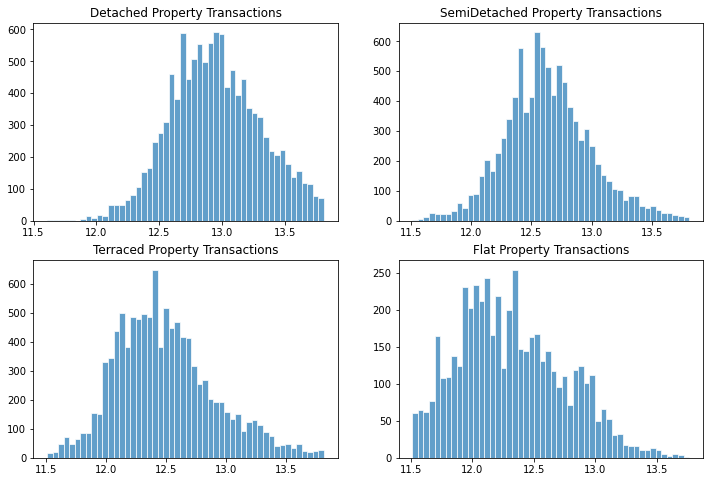

In [170]:
house_types = {'D':'Detached','S':'SemiDetached','T':'Terraced','F':'Flat'}

fig, ax = plt.subplots(2,2,figsize=(12,8))

for k,house_type in enumerate(house_types.keys()):
    j = k % 2
    i = int((k-j)/2)
    ax[i,j].hist(np.log(house_prices_latest[(house_prices_latest['Property Type']==house_type) & \
                                            (house_prices_latest['Price']>=1e5) & \
                                            (house_prices_latest['Price']<1e6)]['Price']),
                 bins=50,alpha=0.7,ec='white')
    ax[i,j].set_title(house_types[house_type]+' Property Transactions')
  

### Geospatial Distributions

Having looked at the distributions in the prices of properties, we can now turn our attention to the geospatial qualities of the data.

As mentioned before `geopandas` uses `matplotlib` as the basis of its plotting functions. This means we can use the `GeoDataFrame.plot()` method as it interacts with our `matplotlib.figure` objects. In the cell below, house prices are plotted on their x and y coordinates using `geopandas` built-in functions, and then tailored as part of a `matplotlib` figure: 

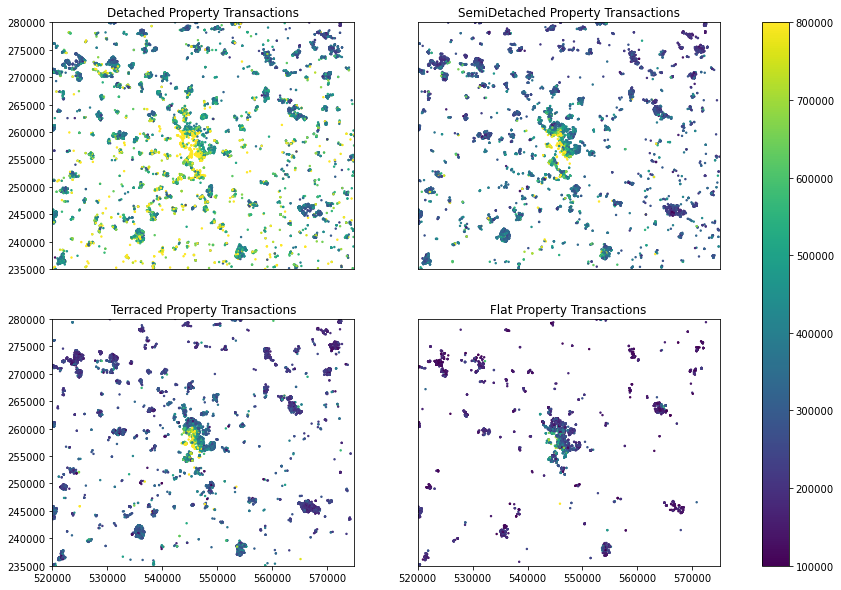

In [149]:
house_types = {'D':'Detached','S':'SemiDetached','T':'Terraced','F':'Flat'}

fig, ax = plt.subplots(2,2,figsize=(15,10))

for k,house_type in enumerate(house_types.keys()):
    j = k % 2
    i = int((k-j)/2)
    house_prices_latest[house_prices_latest['Property Type']==house_type].plot(ax=ax[i,j],
                                                                               column='Price',
                                                                               s=2, vmin=100000, vmax=800000,
                                                                               c=house_prices_latest['Price'])
    ax[i,j].set_title(house_types[house_type]+' Property Transactions')
    ax[i,j].set_xlim((520000,575000))
    ax[i,j].set_ylim((235000,280000))
    if i==0:
        ax[i,j].get_xaxis().set_visible(False)
    if j==1:
        ax[i,j].get_yaxis().set_visible(False)
    
    
fig.colorbar(ax[1,1].collections[0], ax=ax[:,:].ravel(), shrink=1.0)

### Insights

Now this is much more interesting... Immediately we see that property transactions of all types are much more densely situated in the centre of the plot. No surprises, this is roughly the location of the city of Cambridge. Beyond that there are small clusters, towns and villages, of data with generally lower prices surrounding the main block.

> Detached properties, particularly high value detached properties, are spread sparsely around the Cambridge area. But this is what we might expect; really high value properties that come with a lot of land are more likely to be spread away from the city.

> Even taking into account that there were fewer flats sold than any other type, there are significantly fewer flats in the satellite towns and villages vs to Cambridge proper, relative to the other property types. This is not surprising given that flats are a space saving device for city living.

> All property types show a region of higher prices in the South West quadrant of the city, roughly where the University is placed.

## Geospatial Open Data

Finally, I wanted to add some additional detail from other geospatial datasets; for example the positions of roads, rivers, railway lines, stations and bust stops. This data is provided in the for of shapefiles (.shp), and contains information describing lines and polygons rather than the simple points that we've been dealing with so far. The `geopandas` library can load and manipulate this data with ease, so we use that to plot the data on top of house pricing data.

### Planes, Trains, and Automobiles

Ordnance Survey:
- https://osdatahub.os.uk/downloads/open/OpenRoads
- https://osdatahub.os.uk/downloads/open/OpenRivers
- https://osdatahub.os.uk/downloads/open/OpenGreenspace
- https://osdatahub.os.uk/downloads/open/MiniScale
- https://osdatahub.os.uk/downloads/open/Strategi

<!-- Airports:
- https://datashare.is.ed.ac.uk/handle/10283/2563 -->

<!-- Footpaths and Byways:
- http://www.rowmaps.com/jsons/CB/ -->

NaPTAN (National Public Transport Access Nodes):
- https://data.gov.uk/dataset/ff93ffc1-6656-47d8-9155-85ea0b8f2251/national-public-transport-access-nodes-naptan

Noise Pollution:
- https://www.gov.uk/government/publications/strategic-noise-mapping-2019

### Preprocessing

Data preparation such as merging and filtering files is applied using the code in [`preprocessing.py`](https://github.com/millerdw/millerdw.github.io/blob/master/_notebooks/IllustratingThePoint_4/preprocessing/preprocessing.py), but is not run here. 

Further to this we add some custom polygons for Cambridge Airport. It was very hard to find good shapefile data for airport *polygons*, i.e. the outline of airports, so I built my own from a csv of manually measured coordinates. I also added points to represent the line of the airport's runway, reasoning that most planes flying low over the city would be following this path.

The csvs are included on [github repository](https://github.com/millerdw/millerdw.github.io) for this blog in the [./data/Custom](https://github.com/millerdw/millerdw.github.io/tree/master/_notebooks/IllustratingThePoint_4/data/Custom) directory.


In [6]:
airport_coords = pd.read_csv(path.join(directory,'Custom/CambridgeAirport.csv'))
runway_coords = pd.read_csv(path.join(directory,'Custom/CambridgeRunway.csv'))

airport = gpd.GeoDataFrame(index=[0], 
                           geometry=[Polygon(zip(airport_coords['X (Easting)'], airport_coords['Y (Northing)']))],
                           crs=crs)
runway = gpd.GeoDataFrame(index=[0], 
                          geometry=[LineString(zip(runway_coords['X (Easting)'], runway_coords['Y (Northing)']))],
                          crs=crs)


In [7]:
railways=gpd.read_file(path.join(directory,'railway_noise.shp'))
noisy_roads=gpd.read_file(path.join(directory,'road_noise.shp'))
end_noise=gpd.read_file(path.join(directory,'end_noise.shp'))

In [8]:
bus_stops = pd.read_csv(path.join(directory,'NaPTANcsv/Stops.csv'), encoding='Latin')
bus_stops = bus_stops[['NaptanCode','CommonName','Easting', 'Northing','Indicator']]
bus_stops = gpd.GeoDataFrame(bus_stops,
                             geometry=gpd.points_from_xy(bus_stops['Easting'],bus_stops['Northing']))
bus_stops = bus_stops.cx[520000:575000,235000:280000]

C:\Users\Mille\.julia\conda\3\envs\geopython\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (1,2,5,6,7,9,11,13,15,20,21,22,23,24,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
train_stations = pd.read_csv(path.join(directory,'NaPTANcsv/RailReferences.csv'), encoding='Latin')
train_stations = train_stations[['AtcoCode','StationName','CrsCode','Easting', 'Northing']]
train_stations = gpd.GeoDataFrame(train_stations,
                                  geometry=gpd.points_from_xy(train_stations['Easting'],train_stations['Northing']))
train_stations = train_stations.cx[520000:575000,235000:280000]

In [10]:
roads=gpd.read_file(path.join(directory,'os_roads_local.shp'))
greenspaces=gpd.read_file(path.join(directory,'os_greenspaces_local.shp'))
rivers=gpd.read_file(path.join(directory,'os_rivers_local.shp'))

### Plotting Geopandas Data

Now that we've collated all of this data into `GeoDataFrame` objects, it is now relatively easy to plot them together using `geopandas` internal functions.

In the cells below I plot these datasets on top of each other:

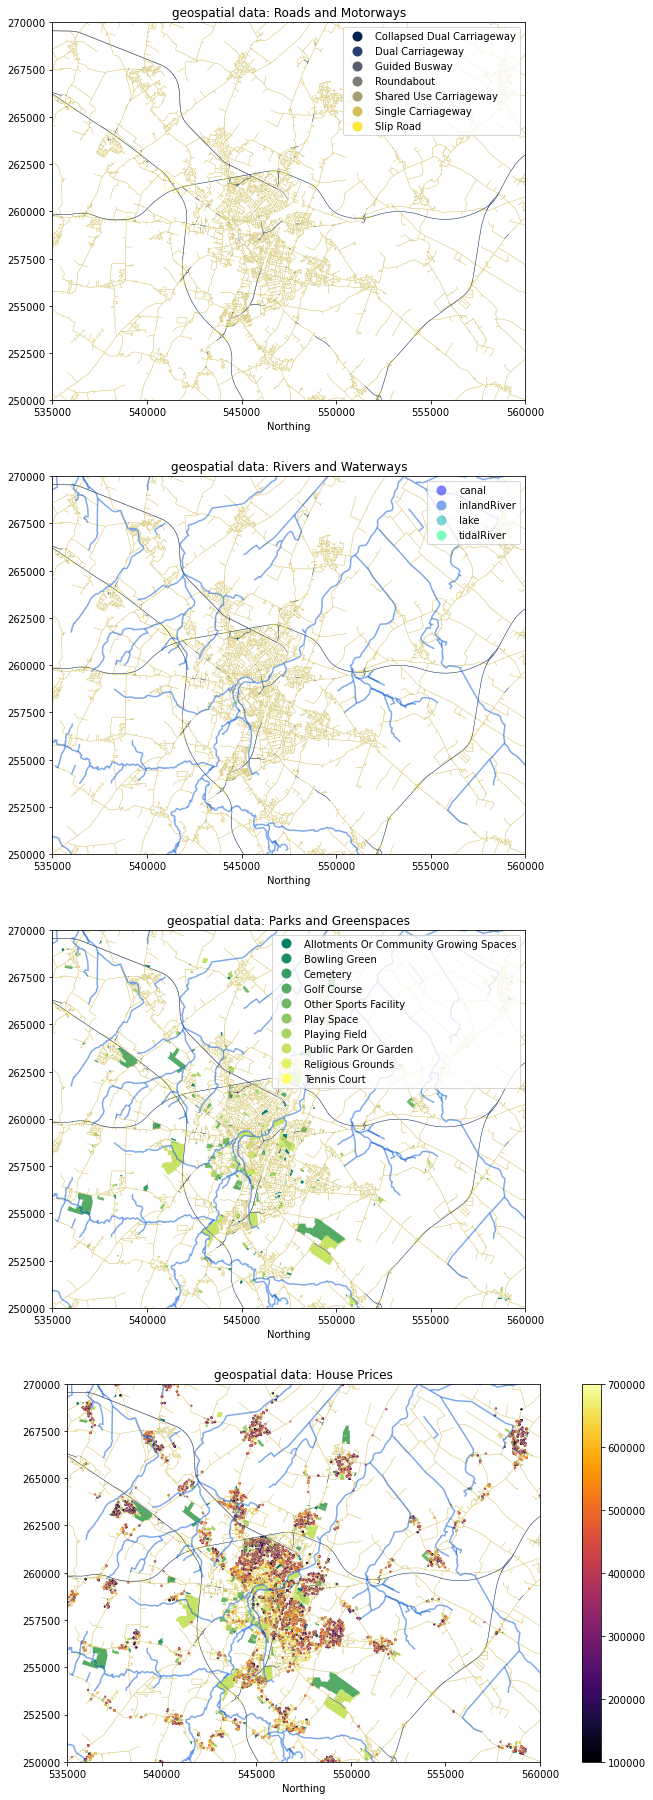

In [23]:
# xmin,xmax=(520000,575000)
# ymin,ymax=(235000,280000)
xmin,xmax=(535000,560000)
ymin,ymax=(250000,270000)

fig,ax=plt.subplots(4,1,figsize=(12*float(xmax-xmin)/float(ymax-ymin),32))

for i,axis in enumerate(ax.ravel()):
    axis.set_xlim((xmin,xmax))
    axis.set_ylim((ymin,ymax))
    axis.set_xlabel('Easting')
    axis.set_xlabel('Northing')
    
    roads.plot(ax=ax[i], 
               column='formOfWay', 
               legend=(i==0),
               cmap=plt.cm.cividis, linewidth=0.5)    
    if i>=1:
        rivers.plot(ax=ax[i],
                    column='form',
                    legend=(i==1),
                    cmap=plt.cm.winter, alpha=0.5)   
    if i>=2:
        greenspaces.plot(ax=ax[i],
                         column='function',
                         legend=(i==2),
                         cmap=plt.cm.summer, linewidth=0.7)

    if i>=3:
        house_prices_latest.plot(ax=ax[i],
                                 column='Price',
                                 s=2, vmin=100000, vmax=700000, 
                                 legend=(i==3),
                                 cmap=plt.cm.inferno, alpha=0.7)
ax[0].set_title('geospatial data: Roads and Motorways')
ax[1].set_title('geospatial data: Rivers and Waterways')
ax[2].set_title('geospatial data: Parks and Greenspaces')
ax[3].set_title('geospatial data: House Prices')
plt.show()

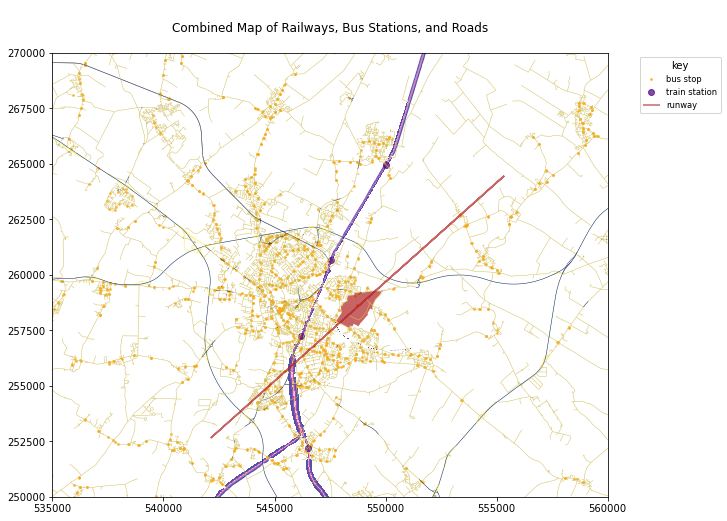

In [237]:

xmin,xmax=(535000,560000)
ymin,ymax=(250000,270000)


plt.figure(figsize=(7.96*float(xmax-xmin)/float(ymax-ymin),10))
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))



roads.plot(ax=plt.gca(), 
           column='formOfWay', 
           cmap=plt.cm.cividis, linewidth=0.5)

railways.plot(ax=plt.gca(), 
              column='noiseclass',
              legend=True,
              cmap=plt.cm.plasma, linewidth=0.5,
              alpha=0.7)


plt.scatter(x=bus_stops['Easting'],
            y=bus_stops['Northing'],
            c='orange',
            label='bus stop',
            s=3,
            alpha=0.7)

plt.scatter(x=train_stations['Easting'],
            y=train_stations['Northing'],
            c='indigo',
            label='train station',
            alpha=0.7)

airport.plot(ax=plt.gca(), 
             label='airport', 
             color='firebrick',
             alpha=0.7)

runway.plot(ax=plt.gca(), 
            label='runway',
            color='firebrick',
            alpha=0.7)

plt.legend(title='key', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title('\nCombined Map of Railways, Bus Stations, and Roads\n')
plt.show()

# Conclusions

Using this data we can calculate distances from roads, airports, green spaces, and rivers, as well as performing clustering in the Easting-Northing Coordinate system to regress house prices given their neighbourhood. This is perfect for building an intuitive machine learning model for regressing house prices from this rich feature set.

I'm aiming to do this (time depending) in a couple of future posts but for now this post demonstrates well the power of the `geopandas` library.

Thanks for reading, and as always, feel free to comment below!